<br>실습 : 가상 고객 데이터 KMeans 클러스터링
- 나이/월소득/지출점수/방문빈도/가입기간/최근방문일 같은 간단한 세그먼트 생성
- Elbow + Silhouette로 K 후보 특정 후 KMeans 적용
- 클러스터 프로파일(원래 스케일 평균)까지 요약

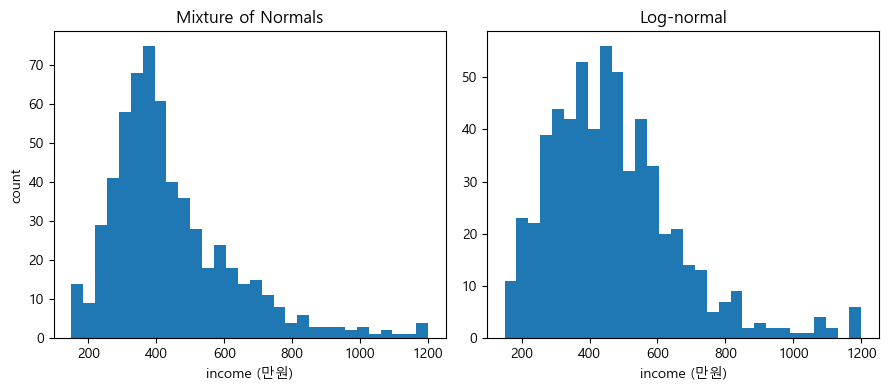

In [84]:
# conda install -c conda-forge kneed
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

rng = np.random.default_rng(42)
n = 600

# 가상 고객 데이터 생성
age = rng.normal(35, 10, n).clip(18, 70)

# 소득(income) 샘플링

# 1) 혼합 정규분포 (로그정규분포 흉내)
income_k = rng.choice([1, 2, 3], size=n, p=[0.6, 0.3, 0.1]) # 소득 그룹
means = {1: 350, 2: 550, 3:750}
stds = {1: 80, 2: 120, 3:200}

income_mixnorm = rng.normal(
	[means[k] for k in income_k],
	[stds[k] for k in income_k], n).clip(150, 1200)
	
# 2) 로그 정규분포
target_mean = 480.0 # 원하는 전체 평균
sigma_log = 0.40 # 로그 분산 : 클수록 오른쪽 꼬리 길어짐. 0.3 ~ 0.5가 중간 정도
mu_log = np.log(target_mean) - 0.5*(sigma_log**2) # 평균 -> mu_log 변환
income_lognorm = rng.lognormal(mean=mu_log, sigma=sigma_log, size=n).clip(150, 1200)

# 시각화 비교
plt.figure(figsize=(9,4))

plt.subplot(1, 2, 1) # 행, 열, 현재 위치
plt.hist(income_mixnorm, bins=30)
plt.title("Mixture of Normals")
plt.xlabel("income (만원)"); plt.ylabel("count");

plt.subplot(1, 2, 2)
plt.hist(income_lognorm, bins=30)
plt.title("Log-normal")
plt.xlabel("income (만원)")

plt.tight_layout()
plt.show()

c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

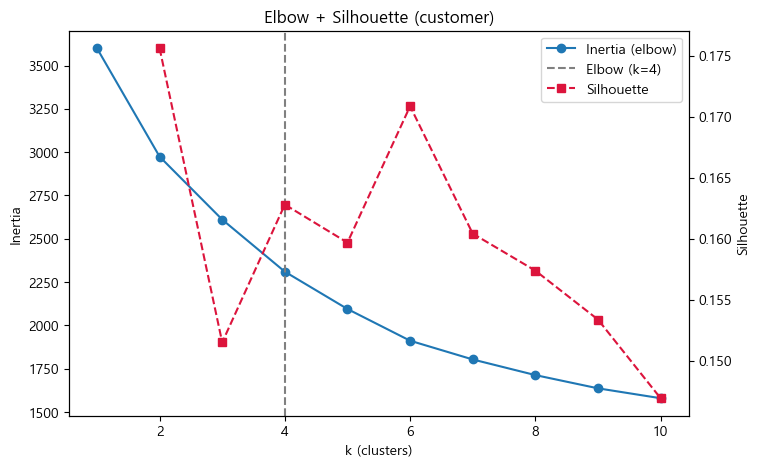

[k 후보] elbow: 4, silhouette: 2


In [85]:
income = income_lognorm

"""
지출 점수 (0 ~ 100)
= 소득 (높을수록 지출도 높게) + 균일 난수 (개인 성향 등 랜덤 요인) + 노이즈
(각각 가중치 0.6, 0.3, 0.1 부여)
"""
spend_score = (0.6* (income/income.max()) +
							 0.3* rng.random(n) +
							 0.1* rng.normal(0.5, 0.2, n)).clip(0, 1) * 100

"""
월 방문 수 : 카운트 -> 포아송

현실성을 높이려면,
포아송보다 더 분산이 큰(과산포) '음이항분포(Negative Binomial)' 사용
- mu : 평균 방문수
- alpha : 과산포 정도 (0이면 포아송과 동일)
- n_param = 1 / alpha
- p_param = n_param / (n_param + mu)
"""
mu = 3.0
visits_poisson = rng.poisson(mu, n).clip(1, 12)

alpha = 0.5
n_param = 1 / alpha
p_param = n_param / (n_param + mu)
visits_nb = rng.negative_binomial(n=n_param, p=p_param, size=n).clip(1, 12)

visits_m = visits_nb

tenure_m = rng.integers(1, 120, n) # 가입개월수 : 고객이 서비스를 얼마나 오래 섰는가
recency_d = rng.integers(1, 90, n) # 최근방문일 : 마지막 방문이 며칠 전인가

df = pd.DataFrame({
	"age": age,
	"income": income,
	"spend_score": spend_score,
	"visits_per_month": visits_m,
	"tenure_months": tenure_m,
	"recency_days": recency_d
})

# 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Elbow & Silhouette -> k 후보
k_max = 11
inertias = []
sils = []

for k in range(1, k_max):
	km = KMeans(n_clusters=k, n_init=10, random_state=42)
	km.fit(X)
	inertias.append(km.inertia_)
	if k > 1:
	  sils.append(silhouette_score(X, km.labels_))
	
knee = KneeLocator(
	list(range(1, k_max)), inertias,
	curve="convex", # Inertia 곡선은 convex
	direction="decreasing" # k ↑ → inertia ↓
)

elbow_k = knee.knee
sil_k = np.argmax(sils) + 2 # 2부터 시작

fig, ax1 = plt.subplots(figsize=(8,5))

# inertias (Elbow)
ax1.plot(list(range(1, k_max)), inertias, marker="o", label="Inertia (elbow)")
ax1.set_xlabel("k (clusters)"); ax1.set_ylabel("Inertia")

plt.axvline(elbow_k, linestyle="--", color="gray", label=f"Elbow (k={elbow_k})")

# silhouettes
ax2 = ax1.twinx()
ax2.plot(list(range(2, k_max)), sils, color="crimson", marker="s", linestyle="--", label="Silhouette")
ax2.set_ylabel("Silhouette")

# legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="best")

plt.title("Elbow + Silhouette (customer)")
plt.show()

print(f"[k 후보] elbow: {elbow_k}, silhouette: {sil_k}")

-> k 후보 범위를 4 ~ 6으로 특정

In [86]:
# 추가지표
"""
Calinski-Harabasz (CH) 지수
: 클러스터 간 분산은 크고, 클러스터 내 분산은 작을수록 좋다
-> CH 값이 클수록 좋고, 빠르고 안정적이라 실무에 자주 쓰인다
Davies-Bouldin (DB) 지수
: 각 클러스터의 응집도 대비 클러스터와의 분리도
-> DB 값이 작을수록 좋고, 실루엣과 함께 보조지표로 사용된다
"""
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

rows = []
for k in range(2, k_max):
	km = KMeans(n_clusters=k, n_init=10, random_state=42)
	labels = km.fit_predict(X)
	
	sil = silhouette_score(X, labels)
	ch = calinski_harabasz_score(X, labels)
	db = davies_bouldin_score(X, labels)
	
	rows.append({"k": k, "silhouette": sil,
							 "calinski_harabasz": ch, "davies_bouldin": db})
							 
scores_df = pd.DataFrame(rows)
print(scores_df.round(4))	

c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

    k  silhouette  calinski_harabasz  davies_bouldin
0   2      0.1756           125.7699          2.0036
1   3      0.1515           113.0589          1.9717
2   4      0.1628           110.9133          1.7102
3   5      0.1597           106.8760          1.5838
4   6      0.1709           104.9025          1.4571
5   7      0.1604            98.4354          1.4779
6   8      0.1574            93.1209          1.4893
7   9      0.1534            88.5858          1.4902
8  10      0.1469            83.8206          1.5006


In [87]:
# 최종 K 선택 후 학습
best_k = 6
print(f"선택된 k = {best_k}")

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

# 원 스케일로 클러스터 프로파일링 (평균/중앙값/클러스터 중심)
"""
평균 / 중앙값
- profile_mean : 각 클러스터에 속한 실제 고객 데이터의 평균
								 (이상치 영향)
- profile_median : 각 클러스터의 특성 중앙값
									 (이상치에 덜 흔들리기 때문에, 꼬리 긴 분포에서는 더 현실적)
"""
profile_mean = df.groupby("cluster").mean(numeric_only=True)
profile_median = df.groupby("cluster").median(numeric_only=True)

print("\n[클러스터별 특성 평균]")
display(profile_mean.round(1))
print("\n[클러스터별 특성 중앙값]")
display(profile_median.round(1))

선택된 k = 6

[클러스터별 특성 평균]


c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,age,income,spend_score,visits_per_month,tenure_months,recency_days
cluster,,,,,,
0,29.1,357.7,35.3,2.6,33.1,63.1
1,43.2,470.4,44.1,2.2,29.2,29.4
2,39.2,436.3,43.2,2.2,87.4,66.6
3,35.6,453.1,44.1,8.5,50.2,40.8
4,32.1,845.1,64.9,3.0,65.3,41.4
5,29.2,422.4,39.9,2.7,81.6,19.6



[클러스터별 특성 중앙값]


,age,income,spend_score,visits_per_month,tenure_months,recency_days
cluster,,,,,,
0,28.9,348.2,35.2,2.0,31.0,65.0
1,41.6,472.1,43.7,2.0,25.5,28.0
2,39.3,443.0,44.1,2.0,90.0,69.0
3,35.1,445.2,44.6,8.0,47.0,39.0
4,31.6,801.0,63.6,2.0,65.0,39.0
5,29.5,417.1,40.9,3.0,84.5,19.0


In [88]:
"""
cluster_centers_
: 각 클러스터의 평균 좌표
	즉, "각 클러스터의 대표 고객의 평균 스펙"
- kmeans.cluster_centers_ 이용
- 스케일링된 공간에서 클러스터링 했으므로, 원스케일로 역변환 후 적용
"""
centers_scaled = kmeans.cluster_centers_ # 각 클러스터의 중심 좌표(스케일된 공간)
centers_orig = pd.DataFrame(
	scaler.inverse_transform(centers_scaled), # 원스케일로 되돌림
	columns=df.columns[:-1] # 클러스터 별
)
centers_orig["cluster"] = range(best_k)
# 원스케일로 되돌린 각 클러스터의 중심 좌표와 클러스터 번호(라벨) 매핑

print("\n[클러스터 평균(원 스케일)]\n")
# display(centers_orig.round(1).reset_index(drop=True))
print(centers_orig.round(1).to_string(index=False))


[클러스터 평균(원 스케일)]

 age  income  spend_score  visits_per_month  tenure_months  recency_days  cluster
29.1   357.7         35.3               2.6           33.1          63.1        0
43.2   470.4         44.1               2.2           29.2          29.4        1
39.2   436.3         43.2               2.2           87.4          66.6        2
35.6   453.1         44.1               8.5           50.2          40.8        3
32.1   845.1         64.9               3.0           65.3          41.4        4
29.2   422.4         39.9               2.7           81.6          19.6        5


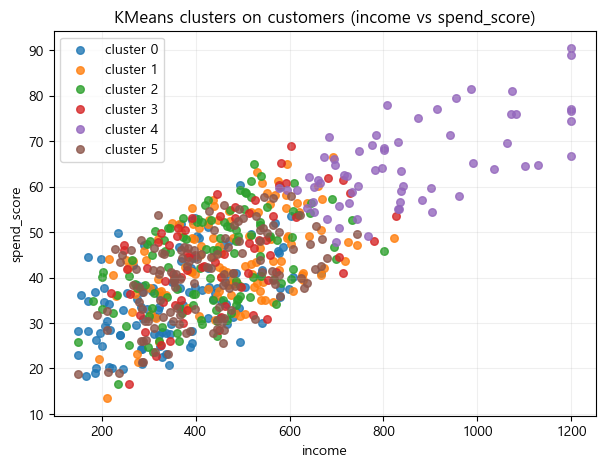

In [89]:
# 간단 시각화 (두 특성으로 투영)
feat_x, feat_y = "income", "spend_score" # "소득 -> 지출점수"로 투영

plt.figure(figsize=(7,5))

# 클러스터별 색상 산점도
for c in range(best_k):
	m = df["cluster"] == c
	plt.scatter(df.loc[m, feat_x], df.loc[m, feat_y], s=30, alpha=0.8, label=f"cluster {c}")

plt.xlabel(feat_x); plt.ylabel(feat_y)
plt.title(f"KMeans clusters on customers ({feat_x} vs {feat_y})")
plt.legend()
plt.grid(alpha=0.2)
plt.show()	 

확장
- 프로파일 표 : 각 군집의 평균/중앙값으로 "고소득/고지출", "저소득/저방문", "충성고객(tenure↑, recency↓)" 같은 세그먼트 라벨링
- VIP 집단 라벨링 목적으로 고객 데이터 생성분포를 바꿔서 의도한 세그먼트가 잘 뽑히는 지 확인